# U Net

## import library

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms.v2 as v2

from torchvision import models
from PIL import Image
from tqdm import tqdm

## class Dataset

In [ ]:
!unzip /content/dataset_seg.zip

In [3]:
class SegmentDataset(data.Dataset):
  def __init__(self, path, transform_img=None, transform_mask=None):
    self.path = path
    self.transform_img = transform_img
    self.transform_mask = transform_mask

    path = os.path.join(self.path, 'images')
    list_file = os.listdir(path)
    self.length = len(list_file)
    self.images = list(map(lambda x: os.path.join(path, x), list_file))

    path = os.path.join(self.path, 'masks')
    list_file = os.listdir(path)
    self.masks = list(map(lambda x: os.path.join(path, x), list_file))

  def __getitem__(self, item):
    path_img, path_mask = self.images[item], self.masks[item]
    img = Image.open(path_img).convert('RGB')
    mask = Image.open(path_mask).convert('L')

    if self.transform_img:
      img = self.transform_img(img)

    if self.transform_mask:
      mask = self.transform_mask(mask)

      mask[mask < 250] = 1
      mask[mask >= 250] = 0

    return img, mask

  def __len__(self):
    return self.length

## U-Net

In [4]:
class UNetSegModel(nn.Module):
  class _TwoConvLayers(nn.Module):
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.model_Two_Conv = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(out_channels),

          nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(out_channels),
      )

    def forward(self, x):
      return self.model_Two_Conv(x)

  class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.block = UNetSegModel._TwoConvLayers(in_channels, out_channels)
      self.max_pool = nn.MaxPool2d(2)

    def forward(self, x):
      x = self.block(x)
      y = self.max_pool(x)
      return y, x

  class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.transpose = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
      self.block = UNetSegModel._TwoConvLayers(in_channels, out_channels)

    def forward(self, x, y):
      x = self.transpose(x)
      u = torch.cat([x, y], dim=1)
      u = self.block(u)
      return u

  def __init__(self, in_channels=3, num_classes=1):
    super().__init__()
    self.enc_block1 = self._EncoderBlock(in_channels, 64)
    self.enc_block2 = self._EncoderBlock(64, 128)
    self.enc_block3 = self._EncoderBlock(128, 256)
    self.enc_block4 = self._EncoderBlock(256, 512)

    self.bottleneck = self._TwoConvLayers(512, 1024)

    self.dec_block1 = self._DecoderBlock(1024, 512)
    self.dec_block2 = self._DecoderBlock(512, 256)
    self.dec_block3 = self._DecoderBlock(256, 128)
    self.dec_block4 = self._DecoderBlock(128, 64)

    self.out = nn.Conv2d(64, num_classes, 1)

  def forward(self, x):
    x, y1 = self.enc_block1(x)
    x, y2 = self.enc_block2(x)
    x, y3 = self.enc_block3(x)
    x, y4 = self.enc_block4(x)

    x = self.bottleneck(x)

    x = self.dec_block1(x, y4)
    x = self.dec_block2(x, y3)
    x = self.dec_block3(x, y2)
    x = self.dec_block4(x, y1)

    return self.out(x)

## loss function

In [5]:
class SoftDiceLoss(nn.Module):
  def __init__(self, smooth=1):
    super().__init__()
    self.smooth = smooth

  def forward(self, logits, target):
    num = target.size(0)
    prods = nn.functional.sigmoid(logits)

    m1 = prods.view(num, -1)
    m2 = target.view(num, -1)
    intersection = (m1*m2)

    score = 2*(intersection.sum(1) + self.smooth) / (m1.sum(1)+m2.sum(1)+self.smooth)
    score = 1-score.sum() / num
    return score

## model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
model = UNetSegModel()
model.to(device)
optimizer = optim.RMSprop(params=model.parameters(), lr=0.001)

loss_1 = nn.BCEWithLogitsLoss()
loss_2 = SoftDiceLoss()

epochs = 30

In [8]:
tr_img = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
tr_mask = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32)])

d_train = SegmentDataset(r"dataset_seg", transform_img=tr_img, transform_mask=tr_mask)
train_data = data.DataLoader(d_train, batch_size=2, shuffle=True, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Train

In [9]:
for _e in range(epochs):
  loss_mean = 0
  lm_count = 0

  train_tqdm = tqdm(train_data, leave=True)
  for x_train, y_train in train_tqdm:
    x_train, y_train = x_train.to(device), y_train.to(device)
    predict = model(x_train)
    loss = loss_1(predict, y_train) + loss_2(predict, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lm_count += 1
    loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
    train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")

st = model.state_dict()
torch.save(st, 'model_unet_seg.tar')

Epoch [30/30], loss_mean=0.728: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


## Test

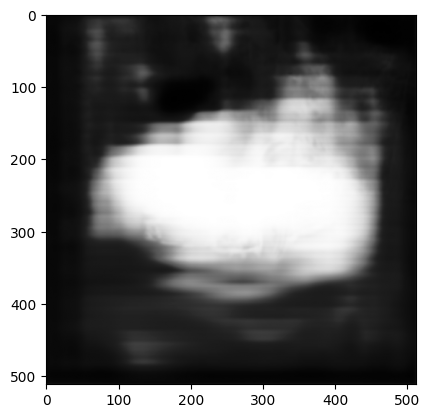

In [11]:
st = torch.load('model_unet_seg.tar', weights_only=False)
model.load_state_dict(st)
model.eval()


tr_img = v2.Compose([
    v2.Resize((512, 512)),  # Подгоняем изображение под нужный размер
    v2.ToTensor()
])

img = Image.open(r'car.jpg').convert('RGB')
img = tr_img(img).unsqueeze(0)  # Добавляем batch dimension
img = img.to(device)
with torch.no_grad():
  p = model(img).squeeze(0)
  x = nn.functional.sigmoid(p.permute(1, 2, 0))
  x = x.detach().cpu().numpy() * 255
  x = np.clip(x, 0, 255).astype('uint8')


plt.imshow(x, cmap='gray')
plt.show()